# **Heston PINN**
---


$$
\frac{\partial V}{\partial t} + rS \frac{\partial V}{\partial S} + \rho\sigma v S \frac{\partial^2 V}{\partial S \partial v} + \frac{1}{2}S^2 v \frac{\partial^2 V}{\partial S^2} + \frac{1}{2}\sigma^2 v \frac{\partial^2 V}{\partial v^2} + \kappa(\theta - v) \frac{\partial V}{\partial v} - rV = 0
$$
<center>

**Heston PDE**
</center>

Where:
* $V$: Option price (a function of $S$, $v$, and $t$)
* $t$: Time
* $S$: Price of the underlying asset
* $v$: Instantaneous variance of the underlying asset (volatility squared)
* $r$: Risk-free interest rate
* $\rho$: Correlation between the Brownian motion of the asset price and its variance
* $\sigma$: Volatility of the variance (volatility of volatility)
* $\kappa$: Rate at which the variance $v$ reverts to its long-term mean $\theta$
* $\theta$: Long-term mean variance

---

## **Import Libraries**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# Common Parameters (from Black-Scholes)
r = 0.05          # Risk-free rate
sigma = 0.2       # Black-Scholes volatility (used for anchoring)
K = 100.0         # Strike price
T = 1.0           # Time to maturity (in years)

# Heston specific Parameters
# We set theta (long-term variance) and v_0 (initial variance)
# to sigma^2 to make the models comparable.
theta = sigma**2  # Long-term variance (0.04)
v_0 = sigma**2    # Initial variance (0.04)
kappa = 2.0       # Rate of mean reversion for variance
sigma_v = 0.3     # Volatility of variance ("vol of vol")
rho = -0.7        # Correlation between asset and variance

# Domain and Grid Setup
# Spatial domain for Stock Price (S)
S_min = 0.0
S_max = 250.0

# Spatial domain for Variance (v)
v_min = 0.0
v_max = 1.0 # The max variance can be adjusted based on model behavior

# Time domain
t_min = 0.0
t_max = T

# Grid points
N = 500

# Create grids for S, t, and v
# These represent the collocation points for training the PINN
S_grid = torch.linspace(S_min, S_max, N).view(-1, 1).requires_grad_()
t_grid = torch.linspace(t_min, t_max, N).view(-1, 1).requires_grad_()
v_grid = torch.linspace(v_min, v_max, N).view(-1, 1).requires_grad_()

## **Define the Model**

In [9]:
class HestonPINN(nn.Module):
    def __init__(self, input_dim=3, output_dim=1, hidden_dim=4, neurons_per_layer=64, activation_fn=nn.Tanh()):
        super().__init__()
        layers = []

        layers.append(nn.Linear(input_dim, neurons_per_layer))
        layers.append(activation_fn)

        for _ in range(hidden_dim - 1):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
            layers.append(activation_fn)

        layers.append(nn.Linear(neurons_per_layer, output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, S, v, t):
        # τ = time-to-maturity
        tau = T - t
        x = torch.cat([S, v, tau], dim=1)

        # Raw NN output
        net_out = self.net(x)

        # Payoff at maturity (European call)
        payoff = torch.clamp(S - K, min=0.0)

        # Enforce terminal condition: at t = T (tau=0), price = payoff exactly
        return payoff + tau * net_out


## **Define the Losses**

In [7]:
def pde_loss(model, S, v, t):
    # Calculates the residual of the Heston PDE

    C = model(S, v, t)
    
    # First derivatives
    C_t = torch.autograd.grad(C, t, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_S = torch.autograd.grad(C, S, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    C_v = torch.autograd.grad(C, v, grad_outputs=torch.ones_like(C), create_graph=True)[0]
    
    # Second derivatives
    C_SS = torch.autograd.grad(C_S, S, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    C_vv = torch.autograd.grad(C_v, v, grad_outputs=torch.ones_like(C_v), create_graph=True)[0]
    C_Sv = torch.autograd.grad(C_S, v, grad_outputs=torch.ones_like(C_S), create_graph=True)[0]
    
    # Heston PDE residual
    pde_residual = (
        C_t
        + r * S * C_S
        + kappa * (theta - v) * C_v
        + 0.5 * v * S**2 * C_SS
        + 0.5 * sigma_v**2 * v * C_vv
        + rho * sigma_v * v * S * C_Sv
        - r * C
    )
    
    return torch.mean(pde_residual**2)


def boundary_loss(model, S_boundary, v_boundary, t_boundary):
    #Calculates the loss at the spatial boundaries (S=0 and S=S_max)

    # Loss at S=0 (option is worthless)
    S_zero = torch.zeros_like(t_boundary).requires_grad_()
    C_at_S_zero = model(S_zero, v_boundary, t_boundary)
    loss_S_zero = torch.mean(C_at_S_zero**2)
    
    # Loss at S=S_max (option behaves like S - K*exp(-r(T-t)))
    S_at_max = (torch.ones_like(t_boundary) * S_max).requires_grad_()
    C_at_S_max_pred = model(S_at_max, v_boundary, t_boundary)
    C_at_S_max_true = S_at_max - K * torch.exp(-r * (T - t_boundary))
    loss_S_max = torch.mean((C_at_S_max_pred - C_at_S_max_true)**2)
    
    # Note: For v boundaries, enforcing the PDE is a common strategy.
    # This is implicitly handled by including v_min and v_max points
    # in the collocation points for the pde_loss.
    
    return loss_S_zero + loss_S_max


def terminal_loss(model, S_terminal, v_terminal):
    # Calculates the loss at the terminal condition (t=T), i.e., the payoff
    
    t_terminal = (torch.ones_like(S_terminal) * T).requires_grad_()
    C_pred = model(S_terminal, v_terminal, t_terminal)
    
    # Payoff for a European Call option: max(S - K, 0)
    C_true = torch.clamp(S_terminal - K, min=0)
    
    return torch.mean((C_pred - C_true)**2)




## **Training**

In [10]:
# Hyperparameters
input_dim       = 3        # Fixed num of inputs (S, v, t)
output_dim      = 1        # Fixed num of outputs (The price)
hidden_dim      = 2        # Num hidden layers
num_neurons     = 256      # Number of neurons per layer
num_epochs      = 7000    # Training epochs
learning_rate   = 0.0024   # Optimizer learning rate

# Number of points to sample for each loss component
N_pde = 2500
N_boundary = 500
N_terminal = 500

# Loss weights (can be tuned)
pde_weight = 9.188
boundary_weight = 0.092
terminal_weight = 0.05

# Model, Optimizer, Scheduler
model = HestonPINN(
    input_dim=input_dim,
    output_dim=output_dim,
    hidden_dim=hidden_dim,
    neurons_per_layer=num_neurons,
    activation_fn=nn.Tanh()
)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-7)

# Training Loop
print("Starting training...")
start_time = time.time()

# Loss History Tracking
loss_history = {
    'total': [],
    'pde': [],
    'boundary': [],
    'terminal': []
}

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # 1. PDE Loss (Interior Points)
    # Sample random points in the (S, v, t) domain
    S_pde = torch.rand(N_pde, 1) * (S_max - S_min) + S_min
    v_pde = torch.rand(N_pde, 1) * (v_max - v_min) + v_min
    t_pde = torch.rand(N_pde, 1) * (t_max - t_min) + t_min
    S_pde.requires_grad = True
    v_pde.requires_grad = True
    t_pde.requires_grad = True
    loss_pde = pde_loss(model, S_pde, v_pde, t_pde)

    # 2. Boundary Loss (S=0 and S=S_max)
    # Sample points on the v and t dimensions for the boundaries
    v_bc = torch.rand(N_boundary, 1) * (v_max - v_min) + v_min
    t_bc = torch.rand(N_boundary, 1) * (t_max - t_min) + t_min
    v_bc.requires_grad = True
    t_bc.requires_grad = True
    loss_bc = boundary_loss(model, None, v_bc, t_bc) # S is handled inside the function
    
    # Combine losses
    total_loss = (pde_weight * loss_pde) + (boundary_weight * loss_bc)
    
    # Backpropagation and optimization
    total_loss.backward()
    optimizer.step()
    
    # Update learning rate scheduler
    scheduler.step(total_loss)

    # Record loss
    loss_history['total'].append(total_loss.item())
    loss_history['pde'].append(loss_pde.item())
    loss_history['boundary'].append(loss_bc.item())
    
    # Print progress
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss.item():.4e}, "
              f"PDE: {loss_pde.item():.4e}, BC: {loss_bc.item():.4e}")

end_time = time.time()
print(f"Training finished in {end_time - start_time:.2f} seconds.")

Starting training...


c:\Users\tobys\miniconda3\envs\star-pinn\lib\site-packages\torch\optim\lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch [100/7000], Loss: 5.8922e+00, PDE: 6.4090e-01, BC: 3.9395e-02
Epoch [200/7000], Loss: 3.9230e+00, PDE: 4.2663e-01, BC: 3.3337e-02
Epoch [300/7000], Loss: 2.6183e+00, PDE: 2.8476e-01, BC: 2.1003e-02
Epoch [400/7000], Loss: 2.1072e+00, PDE: 2.2921e-01, BC: 1.3047e-02
Epoch [500/7000], Loss: 1.6473e+00, PDE: 1.7918e-01, BC: 1.0830e-02
Epoch [600/7000], Loss: 1.6060e+00, PDE: 1.7469e-01, BC: 1.1104e-02
Epoch [700/7000], Loss: 1.5865e+00, PDE: 1.7258e-01, BC: 9.0317e-03
Epoch [800/7000], Loss: 1.4183e+00, PDE: 1.5427e-01, BC: 9.1466e-03
Epoch [900/7000], Loss: 2.7452e+00, PDE: 2.9871e-01, BC: 7.1819e-03
Epoch [1000/7000], Loss: 2.4509e+00, PDE: 2.6661e-01, BC: 1.3985e-02
Epoch [1100/7000], Loss: 1.9303e+00, PDE: 2.1002e-01, BC: 7.4034e-03
Epoch [1200/7000], Loss: 1.6375e+00, PDE: 1.7817e-01, BC: 5.1750e-03
Epoch [1300/7000], Loss: 1.5552e+00, PDE: 1.6920e-01, BC: 5.8532e-03
Epoch [1400/7000], Loss: 1.2825e+00, PDE: 1.3950e-01, BC: 7.9336e-03
Epoch [1500/7000], Loss: 1.2479e+00, PDE: 1

### **Plot Losses**

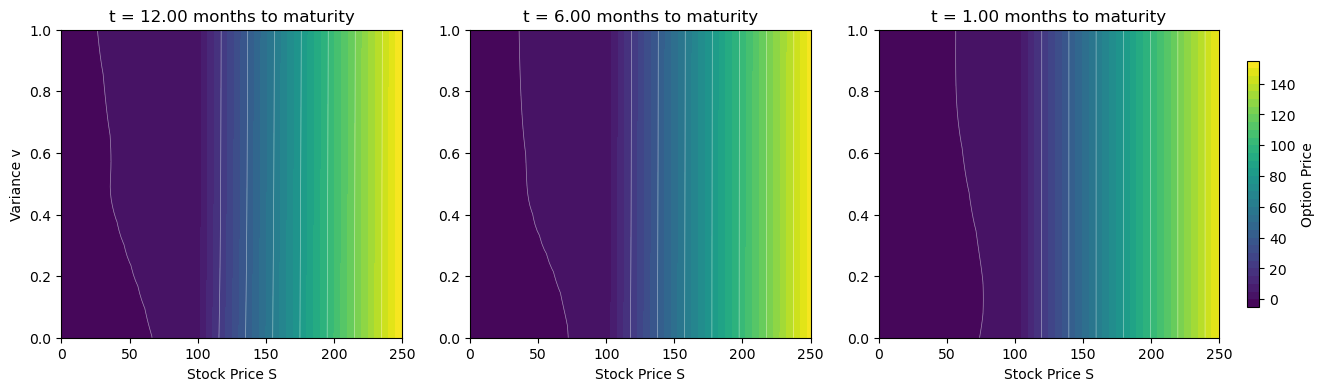

In [79]:
# 1. Build grids as NumPy arrays
S_vals = np.linspace(S_min, S_max, 50)
v_vals = np.linspace(v_min, v_max, 50)
S_grid, v_grid = np.meshgrid(S_vals, v_vals)

# 2. Helper for PINN predictions
def pinn_surface(model, t_fixed):
    S_t = torch.tensor(S_grid.flatten(), dtype=torch.float32).unsqueeze(1)
    v_t = torch.tensor(v_grid.flatten(), dtype=torch.float32).unsqueeze(1)
    t_t = torch.full_like(S_t, fill_value=t_fixed, dtype=torch.float32)

    with torch.no_grad():
        C_pred = model(S_t, v_t, t_t).detach().cpu().numpy().reshape(S_grid.shape)

    return C_pred

# 3. Plot
times = [0 * T, 0.5 * T, 0.917 * T]
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i, t_fixed in enumerate(times):
    C_pred = pinn_surface(model, t_fixed)
    im = axes[i].contourf(S_grid, v_grid, C_pred, levels=30, cmap='viridis')
    axes[i].set_title(f"t = {12 - t_fixed * 12:.2f} months to maturity")
    axes[i].set_xlabel("Stock Price S")
    axes[i].contour(S_grid, v_grid, C_pred, colors='white', linewidths=0.5, alpha=0.5, linestyles='solid')
    if i == 0:
        axes[i].set_ylabel("Variance v")

fig.colorbar(im, ax=axes, location="right", pad=0.02, shrink=0.8, label="Option Price")
plt.show()


C:\Users\tobys\AppData\Local\Temp\ipykernel_22884\3211114931.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


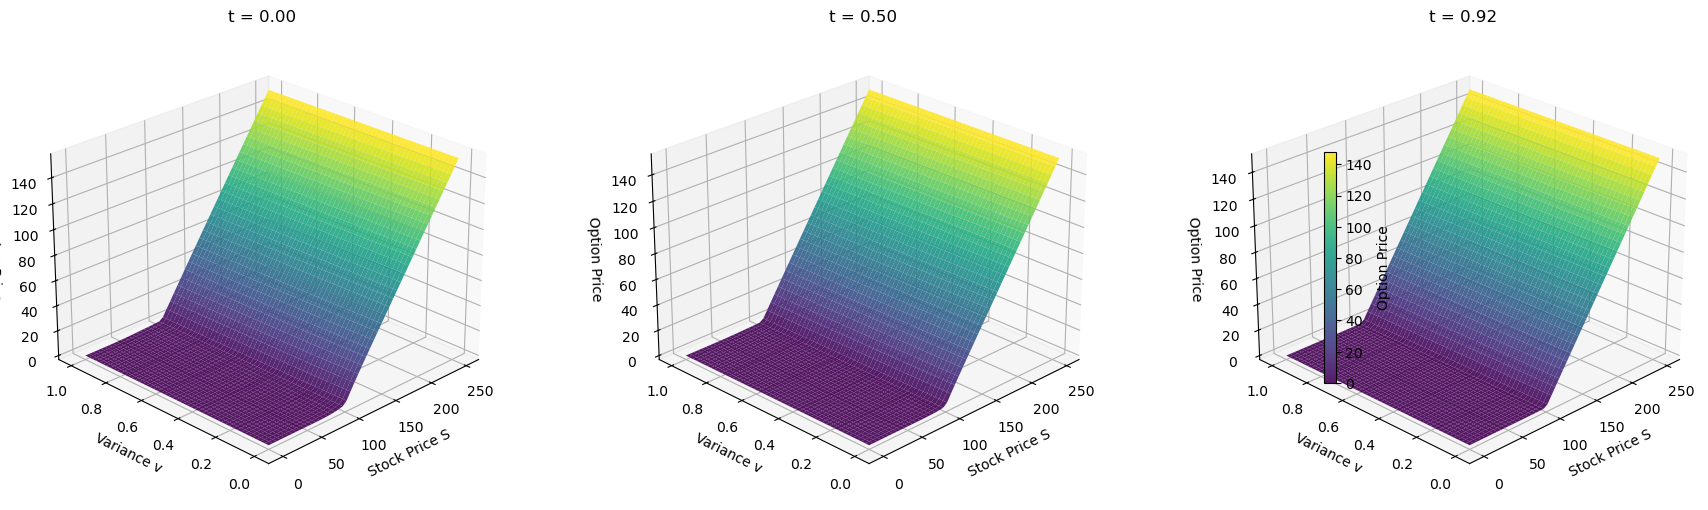

In [68]:
from mpl_toolkits.mplot3d import Axes3D  # not strictly needed in modern mpl, but safe

fig = plt.figure(figsize=(18, 5))

for i, t_fixed in enumerate(times):
    C_pred = pinn_surface(model, t_fixed)  # your helper already returns np array
    
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    surf = ax.plot_surface(S_grid, v_grid, C_pred,
                           cmap='viridis', edgecolor='none', alpha=0.9)
    
    ax.set_title(f"t = {t_fixed:.2f}", fontsize=12)
    ax.set_xlabel("Stock Price S")
    ax.set_ylabel("Variance v")
    ax.set_zlabel("Option Price")
    ax.view_init(elev=25, azim=-135)  # tweak for a nice viewing angle

# shared colorbar to the right
fig.colorbar(surf, ax=fig.get_axes(), shrink=0.6, location="right", pad=0.05, label="Option Price")
plt.tight_layout()
plt.show()
